# CICERO SCM notebook example - interactive input

Import some stuff

In [38]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import xarray as xr
try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Some functions to help with handling my own data

In [43]:
def to_df(cscm):
    """Convert the results of a CICEROSCM object to a DataFrame"""
    out=pd.concat([pd.DataFrame(v) for k, v in cscm.results.items()], axis = 1, keys = list(cscm.results.keys()))
    return out

def calc_beta(mol_mass):
    """Calculate the beta value for a given molecular mass"""
    return 1.7758620689655172e8 * mol_mass * 1e-9


def check_hfc(species):
    """Check if the species is an HFC and remove the hyphen"""
    if "HFC-" in species:
        sp_in = species.replace("-", "")
    else:
        sp_in = species
    return sp_in

def agage_emissions(species):
    """Read AGAGE emissions data for a given species"""
    py_path = f"/user/home/lw13938/work/py12box_agage/data/{species}/outputs/{species}_Global_annual_emissions.csv"
    em_csv = pd.read_csv(py_path, comment="#",index_col=False)
    index = em_csv['Decimal_date'].values.astype(int)
    data = em_csv['Global_annual_emissions'].values
    data[data < 0.] = 0.0
    sp_in = check_hfc(species)
    df = pd.DataFrame(index=index, data=data)
    df.index.name = "Component"
    df.columns = [sp_in]
    return df

def zero_mf(species):
    """Create a DataFrame of zeros for a given species"""
    sp_in = check_hfc(species)
    dfc = pd.DataFrame(index=emi_input.index, columns=[sp_in], data=0)
    dfc.index.name = "Component"
    return dfc

test_data_dir = "/user/home/lw13938/work/ciceroscm/tests/test-data/"

Read in CICERO-SCM datafiles

In [44]:
# Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_gas = pd.read_csv(filename, delim_whitespace=True, index_col=0)


Add AGAGE data and add missing gases. \
Gases are updated with the WMO 2022 lifetimes and SARFs.

In [45]:
# These are all the gases that are considered. Can add more if available or needed.
groups = {"all":[],
          "CFCs": ["CFC-11", "CFC-12", "CFC-113", "CFC-114", "CFC-115","CFC-13"],
          "HCFCs": ["HCFC-22", "HCFC-141b", "HCFC-142b", "HCFC-124", "HCFC-133a"],
          "HFCs": ["HFC-23", "HFC-32", "HFC-134a", "HFC-143a", "HFC-125",
                   "HFC-152a", "HFC-4310mee", "HFC-227ea", "HFC-365mfc",
                   "HFC-236fa", "HFC-245fa"], 
          "Solvents": ["CCl4", "CH3CCl3"],
          "Other":["CF4", "C2F6", "C3F8", "C4F8", "C4F10","C6F14"],
          "Halons": ["H-1301", "H-2402", "H-1211"]}


df_rf = pd.read_csv("/user/home/lw13938/Python/bm_plots/Jens_RF_file/radiative_efficiency.updated.csv", comment="#")
rf_dict = {}
for gi, gas in enumerate(df_rf["Species"].values):
    rf_dict[gas] = df_rf["Recommended Adjusted Effective Radiative Efficiency (W/m2/ppX)"].values[gi]

sp_all = combined_list = [item for sublist in groups.values() for item in sublist]

# Add the extra species
df_si = pd.read_csv("work/py12box/py12box/data/inputs/species_info.csv", index_col=0)
for sp in sp_all:
    sp_in = check_hfc(sp)
    mol_mass = df_si.loc[sp]["Molecular mass (g/mol)"]  
    lifetime = 1/(np.nanmax([1/df_si.loc[sp]["Lifetime stratosphere (years)"],0]) + \
                np.nanmax([1/df_si.loc[sp]["Lifetime other troposphere (years)"],0]) + \
                np.nanmax([1/df_si.loc[sp]["Lifetime ocean (years)"],0]))  
    if sp not in gaspam.index and sp.replace("-","") not in gaspam.index:
        gaspam = pd.concat((gaspam, pd.DataFrame(index=[sp_in], data= {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0})))
    else:
        gaspam.loc[sp_in] = {"EM_UNIT":"Gg", "CONC_UNIT":"ppt", "BETA":calc_beta(mol_mass), "ALPHA":rf_dict[sp]*1e-3, "TAU1":lifetime, "TAU2":0, "TAU3":0, "NAT_EM":0.0, "SARF_TO_ERF":1.0}
        
# Add missing emissions and update with AGAGE numbers where available
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
        
for sp in sp_all:
    if sp not in emi_input.columns and sp.replace("-","") not in emi_input.columns:
        df_sp = agage_emissions(sp).reindex(emi_input.index, fill_value=0)
        emi_input = pd.concat([emi_input, df_sp], axis=1)    
        dfc_sp = zero_mf(sp).reindex(emi_input.index, fill_value=0)
        df_ssp2_conc = pd.concat([df_ssp2_conc, dfc_sp], axis=1)
    else:
        df_sp = agage_emissions(sp)
        sp_in = check_hfc(sp)
        emi_input[sp_in].update(df_sp[sp_in])
df_ssp2_conc = df_ssp2_conc.fillna(0)


Run CICERO-SCM. In each loop, each 'group' of F-gases are zeroed and placed in to a dictionary. 

In [48]:
df_dict = {}

for group in groups:
    emi_input_in = emi_input.copy()
    df_ssp2_conc_in = df_ssp2_conc.copy()
    for species in groups[group]:
        sp_in = check_hfc(species)
        df_ssp2_conc_in[sp_in].values[:] = 0
        emi_input_in[sp_in].values[:] = 0
    # NBVAL_IGNORE_OUTPUT
    scen = 'test'
    cscm_dir=CICEROSCM({
                "gaspam_data": gaspam,
                "emstart": 1750,  
                "conc_run":False,
                "nystart": 1750,
                "nyend": 2024,
                "concentrations_data": df_ssp2_conc_in,
                "emissions_data": emi_input_in,
                "nat_ch4_data": df_nat_ch4,
                "nat_n2o_data": df_nat_n2o,
                "idtm":24,
            })

    # NBVAL_IGNORE_OUTPUT
    cscm_dir._run({
                "results_as_dict":True
            },
        pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                        "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                        "akapa":0.634, #vertical heat diffusivity
                        "cpi":0.4, #temperature change ratio: polar to nonpolar region
                        "W":4, #vertical velocity (m/yr)
                        "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                        "lambda":0.54,
                        "mixed":60.0,  #mixed layer depth
                        "foan":0.61, #fraction of northern hemisphere covered by ocean
                        "foas":0.81, #fraction of northern hemisphere covered by ocean
                        "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                        "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                        "lm":40, #number of vertical layers
                        "ldtime":12,
                    },
        pamset_emiconc={"lamb": 0.8,
                        "qbmb":0.03,
                        "qo3":0.4,
                        "qdirso2":-.457,
                        "qindso2":-.514,
                        "qbc":.2,
                        "qh2o_ch4":.171,
                        "qoc":-.103,
                        "ref_yr":2010,
                        "idtm":24})
    df_temp = to_df(cscm_dir)
    temp = np.squeeze(df_temp['dT_glob'].values)
    temp = temp[np.isfinite(temp)]
    df_dict[group] = temp

/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_data = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_data = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_data = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_data = pd.read_csv(
/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureW

Plot impact of each group on temperature rise. \
Plot halons last as their impact is negative.

Text(0.5, 0, 'Year')

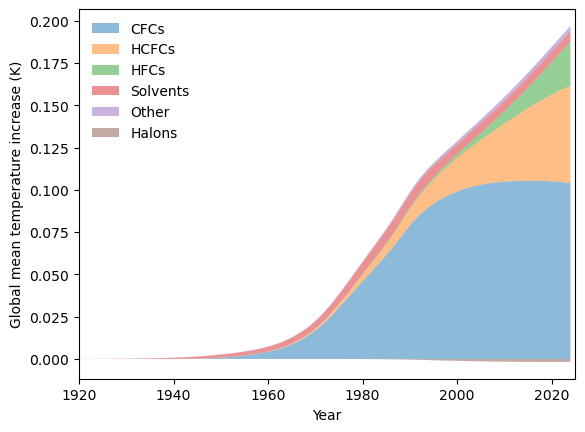

In [49]:
year = df_temp['concentrations'].Year.values
year = year[np.isfinite(year)]
tpr = np.zeros(len(year))
temp0 = np.squeeze(df_dict["all"])
for gr in list(df_dict.keys())[1:6]:
    temp = temp0 - df_dict[gr]
    plt.fill_between(year, tpr, tpr+temp, label=gr, alpha=0.5)
    tpr = tpr+temp
temp = temp0 - df_dict["Halons"]   
plt.fill_between(year, np.zeros(len(year)), temp, label="Halons", alpha=0.5)
plt.legend(loc="upper left", frameon=False)
plt.xlim(1920,2025)
plt.ylabel("Global mean temperature increase (K)")
plt.xlabel("Year")

# Do it for comparative gas rise since 1920

In [52]:
emi_input_in = emi_input.copy()
df_ssp2_conc_in = df_ssp2_conc.copy()
sp_in = "HFC23"
# df_ssp2_conc_in[sp_in].values[:] = 0#df_ssp2_conc_in[sp_in].values/50
emi_input_in[sp_in].values[:] = 0#emi_input_in[sp_in].values/50
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2024,
            "concentrations_data": df_ssp2_conc_in,
            "emissions_data": emi_input_in,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

# NBVAL_IGNORE_OUTPUT
cscm_dir._run({
            "results_as_dict":True
        },
    pamset_udm={"threstemp": 7.0, #scales vertical velocity as a function of mixed layer temperature
                    "rlamdo":16.0,#air-sea heat exchange coefficient (wm^-2K^-1)
                    "akapa":0.634, #vertical heat diffusivity
                    "cpi":0.4, #temperature change ratio: polar to nonpolar region
                    "W":4, #vertical velocity (m/yr)
                    "beto":3.5, #ocean interhemispheric heat exchange coeff (Wm^-2K^-1)
                    "lambda":0.54,
                    "mixed":60.0,  #mixed layer depth
                    "foan":0.61, #fraction of northern hemisphere covered by ocean
                    "foas":0.81, #fraction of northern hemisphere covered by ocean
                    "ebbeta":0.0,#atmospheric interhemispheric heat exchange 
                    "fnso":0.7531, #ocean area ratio, northern to southern hemisphere
                    "lm":40, #number of vertical layers
                    "ldtime":12,
                },
    pamset_emiconc={"lamb": 0.8,
                    "qbmb":0.03,
                    "qo3":0.4,
                    "qdirso2":-.457,
                    "qindso2":-.514,
                    "qbc":.2,
                    "qh2o_ch4":.171,
                    "qoc":-.103,
                    "ref_yr":2010,
                    "idtm":24})
df_temp = to_df(cscm_dir)
temp = np.squeeze(df_temp['dT_glob'].values)
temp = temp[np.isfinite(temp)]
df_dict[sp_in] = temp


/user/work/lw13938/ciceroscm/src/ciceroscm/input_handler.py:513: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_data = pd.read_csv(


Text(0.5, 0, 'Year')

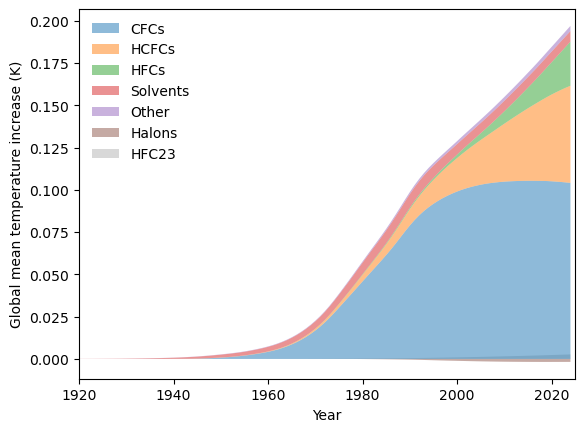

In [53]:
cutyear = 1920
year = df_temp['concentrations'].Year.values
year = year[np.isfinite(year)]
tpr = np.zeros(len(year))
temp0 = np.squeeze(df_dict["all"])
for gr in list(df_dict.keys())[1:6]:
    temp = temp0 - df_dict[gr]
    plt.fill_between(year, tpr, tpr+temp, label=gr, alpha=0.5)
    tpr = tpr+temp
temp = temp0 - df_dict["Halons"]   
plt.fill_between(year, np.zeros(len(year)), temp, label="Halons", alpha=0.5)

tpr = np.zeros(len(year))
temp0 = np.squeeze(df_dict["all"])
gr = sp_in
temp = temp0 - df_dict[gr] - (temp0 - df_dict[gr])[year == cutyear]
plt.fill_between(year, tpr, tpr+temp, label=gr, alpha=0.3, zorder=0, facecolor="grey")
plt.legend(loc="upper left", frameon=False)
plt.xlim(1920,2025)
# plt.ylim(-0.01,0.23)
plt.ylabel("Global mean temperature increase (K)")
plt.xlabel("Year")
